#### agreggation du sentiment au niveau journalier 

In [1]:
import pandas as pd
import numpy as np
import os

DATA_DIR = "data"
FILE_FR = "finbert_articles_fr_final_test.csv"
FILE_DE = "finbert_articles_de_final_test.csv"
OUTPUT_FILE = "aggregated_daily_finbert_test.csv"

def load_and_aggregate_daily(filename):
    path = os.path.join(DATA_DIR, filename)
    df = pd.read_csv(path)

    col_date = 'date'
    # Conversion en Datetime UTC, puis suppression de la Timezone et de l'heure
    df['dt'] = pd.to_datetime(df[col_date], utc=True, errors='coerce')
    df['date_clean'] = df['dt'].dt.tz_localize(None).dt.normalize()
    
    # Agrégation : Moyenne des scores pour chaque jour
    daily_series = df.groupby('date_clean')['sentiment_score'].mean()
    return daily_series

sent_fr = load_and_aggregate_daily(FILE_FR)
sent_de = load_and_aggregate_daily(FILE_DE)

start_date = min(sent_fr.index.min(), sent_de.index.min())
end_date = max(sent_fr.index.max(), sent_de.index.max())
full_index = pd.date_range(start=start_date, end=end_date, freq='D')
    
df_aligned = pd.DataFrame(index=full_index)
df_aligned.index.name = 'date'

df_aligned['sent_fr'] = sent_fr
df_aligned['sent_de'] = sent_de
    
# IMPUTATION DES DONNÉES MANQUANTES (Week-ends / Jours sans news)
# limit=5 : On ne bouche pas des trous de plus de 5 jours
df_aligned = df_aligned.interpolate(method='time', limit=5)
    
# DIFFERENTIEL
df_aligned['sentiment_diff'] = df_aligned['sent_fr'] - df_aligned['sent_de']
    
# LISSAGE
# Moyenne mobile 7 jours
df_aligned['sent_fr_ma7'] = df_aligned['sent_fr'].rolling(7).mean()
df_aligned['sent_de_ma7'] = df_aligned['sent_de'].rolling(7).mean()
df_aligned['diff_ma7'] = df_aligned['sentiment_diff'].rolling(7).mean()

out_path = os.path.join(DATA_DIR, OUTPUT_FILE)
df_aligned.to_csv(out_path)

#### graphs

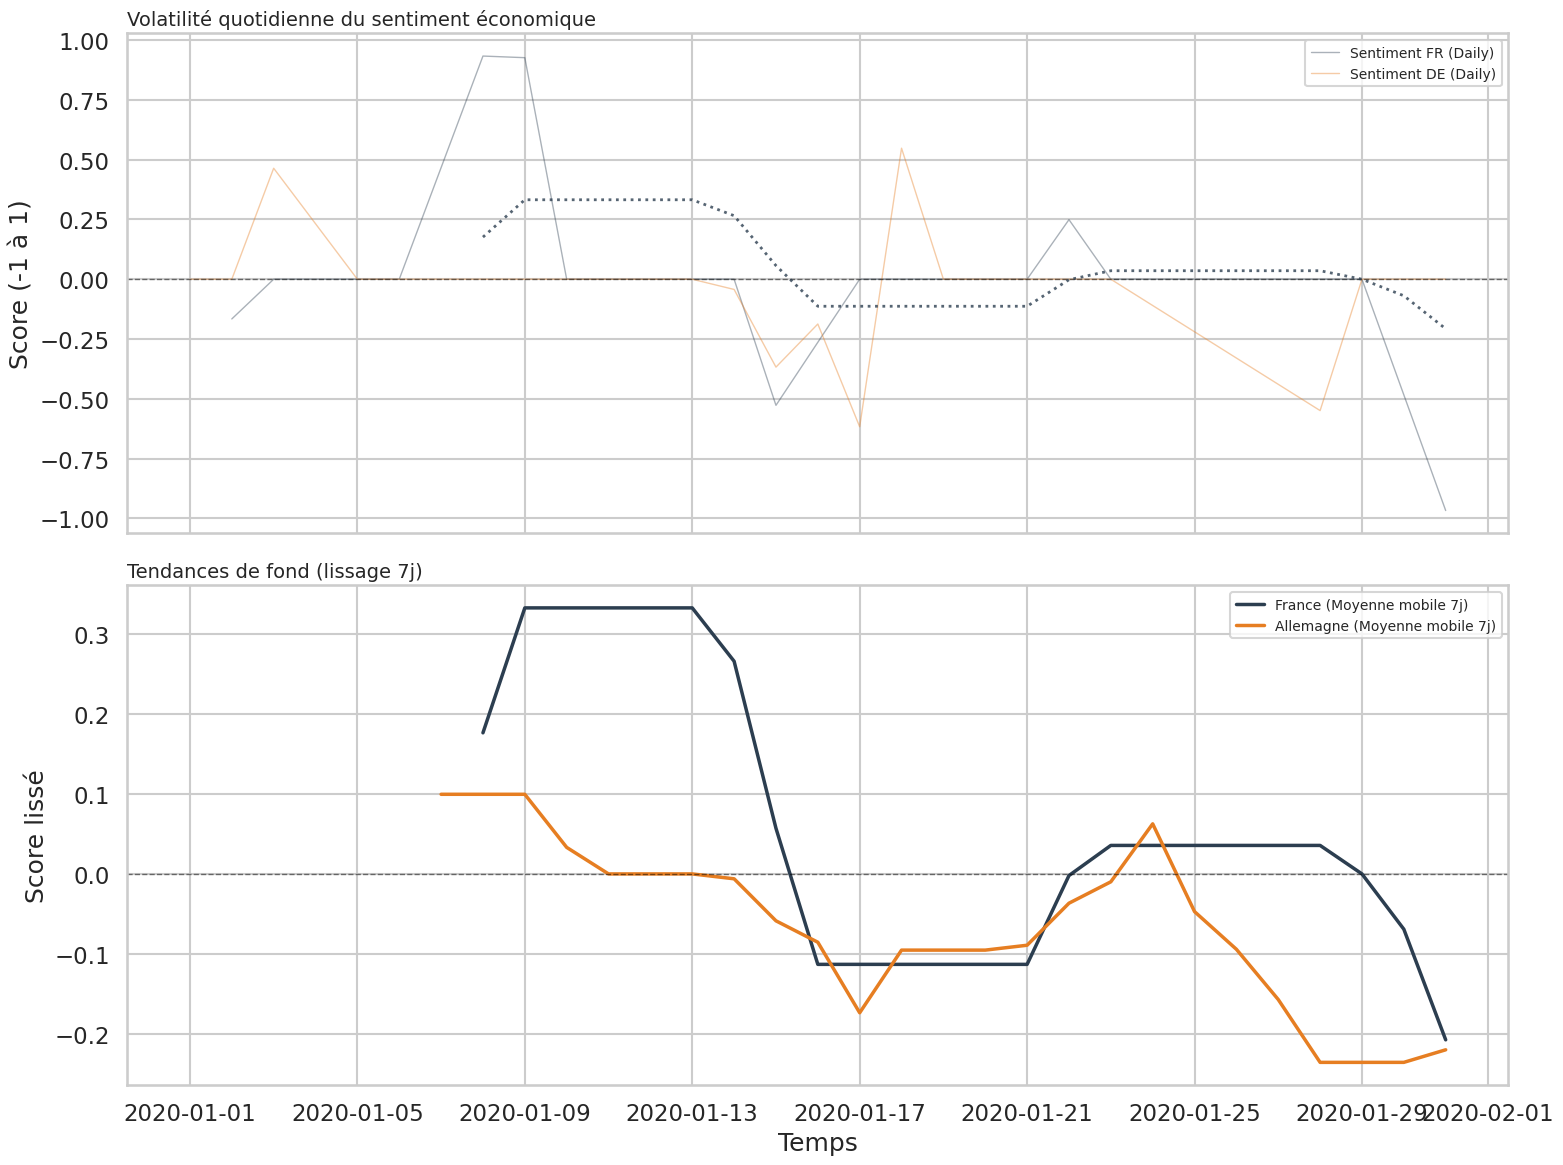

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

DATA_DIR = "data"
INPUT_FILE = "aggregated_daily_finbert_test.csv"
path = os.path.join(DATA_DIR, INPUT_FILE)
df = pd.read_csv(path, index_col=0, parse_dates=True)
    
    # --- DATES À DÉFINIR ICI ---
    # Pour zoomer, remplace par : pd.Timestamp("2022-01-01")
#START_DATE = df.index.min()
#END_DATE = df.index.max()
START_DATE = pd.Timestamp("2020-01-01")
END_DATE = pd.Timestamp("2020-01-31")

mask = (df.index >= START_DATE) & (df.index <= END_DATE)
plot_df = df.loc[mask]

    # ==========================================
    # 2. GRAPHIQUE DOUBLE (BRUT vs LISSÉ)
    # ==========================================
sns.set_theme(style="whitegrid", context="talk") # Style "Papier de recherche"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

    # COULEURS (Palette académique)
col_fr = '#2c3e50'  # Bleu sombre (France)
col_de = '#e67e22'  # Orange (Allemagne)

    # --- GRAPHIQUE 1 : Sentiment Journalier (Volatil) ---
ax1.plot(plot_df.index, plot_df['sent_fr'], color=col_fr, alpha=0.4, linewidth=1, label='Sentiment FR (Daily)')
ax1.plot(plot_df.index, plot_df['sent_de'], color=col_de, alpha=0.4, linewidth=1, label='Sentiment DE (Daily)')
ax1.set_title("Volatilité quotidienne du sentiment économique", fontsize=14, loc='left')
ax1.set_ylabel("Score (-1 à 1)")
ax1.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax1.legend(loc='upper right', frameon=True, fontsize=10)

    # --- GRAPHIQUE 2 : Tendance Hebdomadaire (MA7 - Signal Macro) ---
    # C'est ce signal que ton modèle économétrique va probablement utiliser
if 'sent_fr_ma7' in plot_df.columns:
    ax1.plot(plot_df.index, plot_df['sent_fr_ma7'], color=col_fr, linewidth=2, linestyle=':', alpha=0.8, label='_nolegend_') # Juste pour guider l'oeil sur le graph 1
        
    ax2.plot(plot_df.index, plot_df['sent_fr_ma7'], color=col_fr, linewidth=2.5, label='France (Moyenne mobile 7j)')
    ax2.plot(plot_df.index, plot_df['sent_de_ma7'], color=col_de, linewidth=2.5, label='Allemagne (Moyenne mobile 7j)')
    
    ax2.set_title("Tendances de fond (lissage 7j)", fontsize=14, loc='left')
    ax2.set_ylabel("Score lissé")
    ax2.set_xlabel("Temps")
    ax2.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
    
    # Ajout des zones de crise (Optionnel, pour l'habillage)
    # Tu pourras ajouter tes propres axvspan pour marquer le début du Covid ou de l'Ukraine
    
    ax2.legend(loc='upper right', frameon=True, fontsize=10)

    plt.tight_layout()
    plt.show()

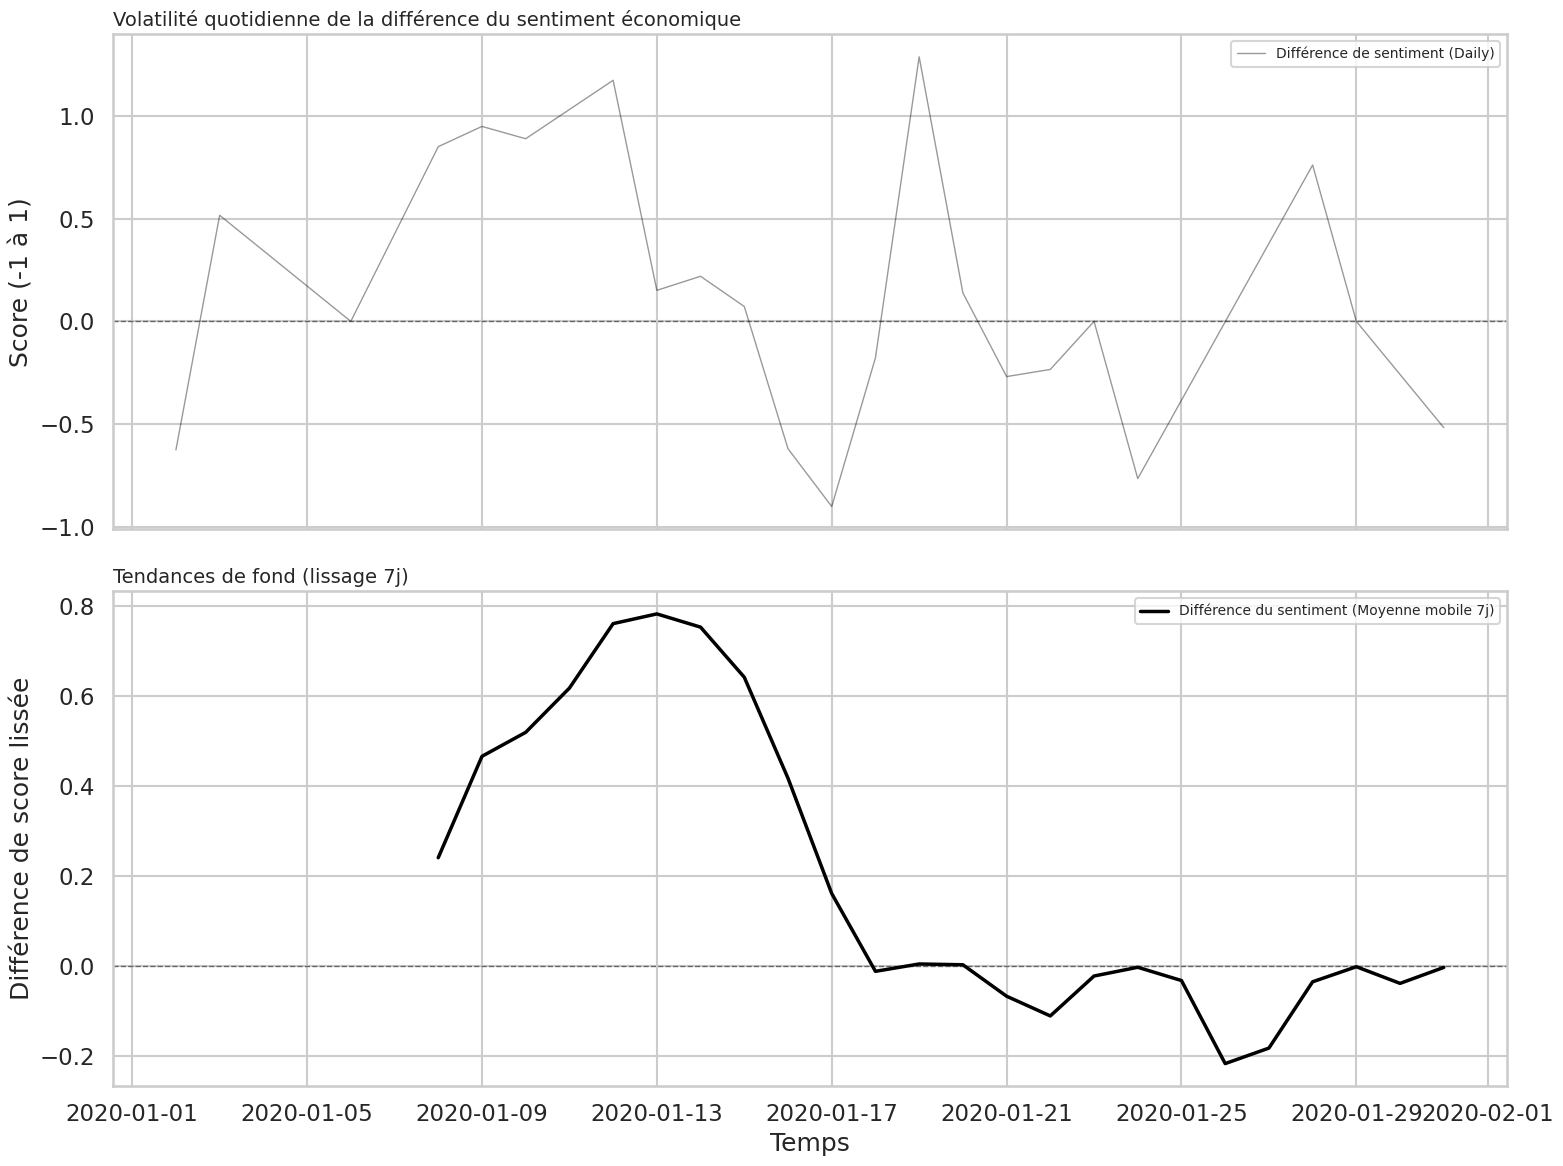

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

DATA_DIR = "data"
INPUT_FILE = "daily_sentiment_aligned.csv"
path = os.path.join(DATA_DIR, INPUT_FILE)
df = pd.read_csv(path, index_col=0, parse_dates=True)
    
    # --- DATES À DÉFINIR ICI ---
    # Pour zoomer, remplace par : pd.Timestamp("2022-01-01")
#START_DATE = df.index.min()
#END_DATE = df.index.max()
START_DATE = pd.Timestamp("2020-01-01")
END_DATE = pd.Timestamp("2020-01-31")

mask = (df.index >= START_DATE) & (df.index <= END_DATE)
plot_df = df.loc[mask]

    # ==========================================
    # 2. GRAPHIQUE DOUBLE (BRUT vs LISSÉ)
    # ==========================================
sns.set_theme(style="whitegrid", context="talk") # Style "Papier de recherche"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)


    # --- GRAPHIQUE 1 : Sentiment Journalier (Volatil) ---
ax1.plot(plot_df.index, plot_df['sentiment_diff'], color='black', alpha=0.4, linewidth=1, label='Différence de sentiment (Daily)')
ax1.set_title("Volatilité quotidienne de la différence du sentiment économique", fontsize=14, loc='left')
ax1.set_ylabel("Score (-1 à 1)")
ax1.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax1.legend(loc='upper right', frameon=True, fontsize=10)

    # --- GRAPHIQUE 2 : Tendance Hebdomadaire (MA7 - Signal Macro) ---
    # C'est ce signal que ton modèle économétrique va probablement utiliser
if 'diff_ma7' in plot_df.columns:
        
    ax2.plot(plot_df.index, plot_df['diff_ma7'], color='black', linewidth=2.5, label='Différence du sentiment (Moyenne mobile 7j)')
    
    ax2.set_title("Tendances de fond (lissage 7j)", fontsize=14, loc='left')
    ax2.set_ylabel("Différence de score lissée")
    ax2.set_xlabel("Temps")
    ax2.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
        
    ax2.legend(loc='upper right', frameon=True, fontsize=10)

    plt.tight_layout()
    plt.show()